In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies
# and more convolutional layers involved

In [2]:
# Usual loading of recorded data
from sklearn.model_selection import train_test_split
from core_functions import load_data
import numpy as np

Xraw, yraw = load_data("./second_collection_triggs_rels_32.npz")
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.15, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.15, random_state=42)

def normalize(x):   
    # Hard code a value based on the training set
    # xmax = np.mean(np.max(Xtrain, axis=1))     # Hard coding the normalization severely affects validation accuracy
    xmax = np.max(x, axis=1)[:, np.newaxis]
    return x / xmax 

Xtrain = normalize(Xtrain) 
Xtest = normalize(Xtest)
Xval = normalize(Xval)

print("Raw data shape: ", Xraw.shape)
print("Labels shape: ", yraw.shape)
print("Unique labels: ", np.unique(yraw))
print("Size of test set:", Xtest.shape)
print("Size of train set:", Xtrain.shape)
print("Size of validation set:", Xval.shape)
print("Fraction of single class in test set: ", np.mean(ytest==0))
print("\nTrain, Test and Validation set were normalized!")

def buildDataset(X, y):
    """Builds dataset to be compatible with PyTorch"""
    return [[np.array(x)[np.newaxis, :], y] for (x, y) in zip(X, y)]

trainset = buildDataset(Xtrain, ytrain)
# valset = buildDataset(Xval, yval) 
# testset = buildDataset(Xtest, ytest) 

Raw data shape:  (7891, 32)
Labels shape:  (7891,)
Unique labels:  [0 1 2]
Size of test set: (1184, 32)
Size of train set: (5700, 32)
Size of validation set: (1007, 32)
Fraction of single class in test set:  0.2981418918918919

Train, Test and Validation set were normalized!


In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dtype = torch.float32

print("Using Device: ", device)

# General function for training each model
def trainModel(model, trainset, batch_size=32, learning_rate=5e-4, max_epochs=20, weight_decay=1e-4):
    """General training procedure for all models"""

    # Build data loader to seperate data into batches
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    # Use same criterion for all models, cross entropy is good for classification problems
    criterion = nn.CrossEntropyLoss()       
    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Pass to GPU if available
    model = model.to(device)
    # Apply the same initialization every time for reproducibility
    model.apply(weight_init)
    
    losses = []        # Track loss function
    accuracies = []    # Track train, validation and test accuracies
    for epoch in range(max_epochs):  # Loop over the dataset multiple times

        for i, (sig, y) in enumerate(train_loader):   # sig and y are batches 
            model.train() # Explicitly set to model to training 

            # Pass arrays to GPU
            sig = sig.to(device, dtype=dtype)
            y = y.to(device, dtype=torch.long)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(sig)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            # Store results
            if i % 100 == 0:
                losses.append(loss.item())
                acc = getAcc(model)    
                accuracies.append(acc)
                print(f"Epoch {epoch+1}, Batch {i+1}: loss={loss.item():5.3f}, train={acc[0]*100:4.1f}%, val={acc[1]*100:4.1f}%")

    print("Training Complete!")
    return np.array(losses), np.array(accuracies)


def weight_init(m):
    """
    Method to insure that weights of each layer are initialized always to 
    the same values for reproducibiity
    """
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.manual_seed(180200742)
        nn.init.kaiming_normal_(m.weight)     # Read somewhere that Kaiming initialization is advisable
        nn.init.zeros_(m.bias)


def toTensor(X, y):
    xt = torch.tensor(X[:, np.newaxis, :], dtype=dtype)
    yt = torch.tensor(y, dtype=torch.long)
    return xt, yt 

xtr, ytr = toTensor(Xtrain, ytrain)
xv, yv = toTensor(Xval, yval)
xte, yte = toTensor(Xtest, ytest)

def getAcc(model, test=False):
    """
    Returns accuracies of training data trainloader and test data valloader
    Uses zip, so that the number of points in the training data will match validation data.
    """
    with torch.no_grad():  # Avoid computing the gradients

        def acc(x, y):
            out = model(x)
            _, pred = torch.max(out.data, 1)
            return (pred==y).detach().numpy().mean()

        if test:
            return [acc(xte, yte)]
        return [acc(xtr, ytr), acc(xv, yv)]

Using Device:  cpu


In [4]:
# Convolutional architecture with 3 layers
# Investigate how number of channels and kernel size changes the results
class CNN2(nn.Module):    
    def __init__(self, channels, kernels, h_neurons, p_drop):
        super(CNN2, self).__init__()
     
        ch1, ch2, ch3 = channels
        k1, k2, k3 = kernels
        pad1, pad2, pad3 = int((k1-1)/2), int((k2-1)/2), int((k3-1)/2)
        h1, h2 = h_neurons
        p1, p2, p3 = p_drop

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, ch1, kernel_size=k1, padding=pad1),
            nn.Dropout(p1),
            nn.ReLU(),
            nn.Conv1d(ch1, ch2, kernel_size=k2, padding=pad2),
            nn.Dropout(p2),
            nn.ReLU(),
            nn.Conv1d(ch2, ch3, kernel_size=k3, padding=pad3),
            nn.Dropout(p3),
            nn.ReLU(),
            nn.MaxPool1d(4)   # Single pool layer with kernel=4 gave better results than 2 pool layers with kernel=2
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(ch3 * 7, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

# Fix kernels
kernels = [5, 5, 5]
# Test 3 different channels
channels = [16, 16, 16]      # Keep sizes of channels the same because there is not reduction in the image
# Test different sizes of hidden layers 
h_neurons = [300, 200]
# Test different rates of Dropout
p_drop = [[0, 0, 0]]

#Run training  
# Initialize results
models, models_losses, models_acc, models_label = [], [], [], []
for i, pp in enumerate(p_drop):

    model = CNN2(channels, kernels, h_neurons, pp)

    # Train
    losses, accuracies = trainModel(model, trainset, batch_size=64, max_epochs=30)

    models.append(model)
    models_losses.append(losses)
    models_acc.append(accuracies)
    models_label.append(f"model {i}, dropout={pp}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 112x300)

In [5]:
# Model with usual halving of image size and doubling the depth
class CNN_STANDARD(nn.Module):    
    def __init__(self):
        super(CNN_STANDARD, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(16 * 4, 384),
            nn.ReLU(),
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

# Run training
models, models_losses, models_acc, models_label = [], [], [], []
for i, wd in enumerate([1e-4]):

    model = CNN_STANDARD() 

    # Train
    losses, accuracies = trainModel(model, trainset, learning_rate=5e-3, batch_size=128, max_epochs=100, weight_decay=wd)

    models.append(model)
    models_losses.append(losses)
    models_acc.append(accuracies)
    models_label.append(f"model {i}, wd={wd}")

Epoch 1, Batch 1: loss=1.106, train=38.6%, val=40.5%
Epoch 2, Batch 1: loss=0.861, train=58.1%, val=56.6%
Epoch 3, Batch 1: loss=0.771, train=59.1%, val=58.7%
Epoch 4, Batch 1: loss=0.839, train=66.6%, val=67.0%
Epoch 5, Batch 1: loss=0.688, train=65.4%, val=67.0%
Epoch 6, Batch 1: loss=0.676, train=69.9%, val=69.8%
Epoch 7, Batch 1: loss=0.808, train=70.1%, val=69.9%
Epoch 8, Batch 1: loss=0.665, train=71.6%, val=73.1%
Epoch 9, Batch 1: loss=0.593, train=72.6%, val=72.8%
Epoch 10, Batch 1: loss=0.634, train=72.5%, val=71.9%
Epoch 11, Batch 1: loss=0.695, train=74.9%, val=77.6%
Epoch 12, Batch 1: loss=0.654, train=72.5%, val=74.3%
Epoch 13, Batch 1: loss=0.547, train=74.8%, val=75.9%
Epoch 14, Batch 1: loss=0.585, train=76.6%, val=78.3%
Epoch 15, Batch 1: loss=0.488, train=76.0%, val=78.0%
Epoch 16, Batch 1: loss=0.464, train=78.2%, val=78.0%
Epoch 17, Batch 1: loss=0.423, train=78.4%, val=79.7%
Epoch 18, Batch 1: loss=0.590, train=78.3%, val=78.5%
Epoch 19, Batch 1: loss=0.440, train=

Accuracy of test set of best model (idx=0): 86.1%


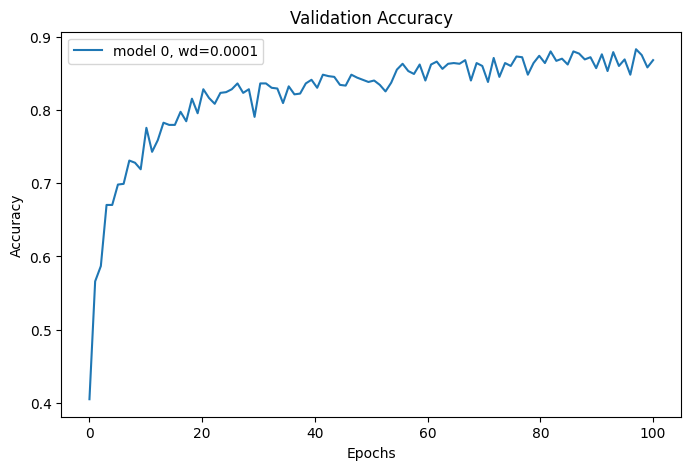

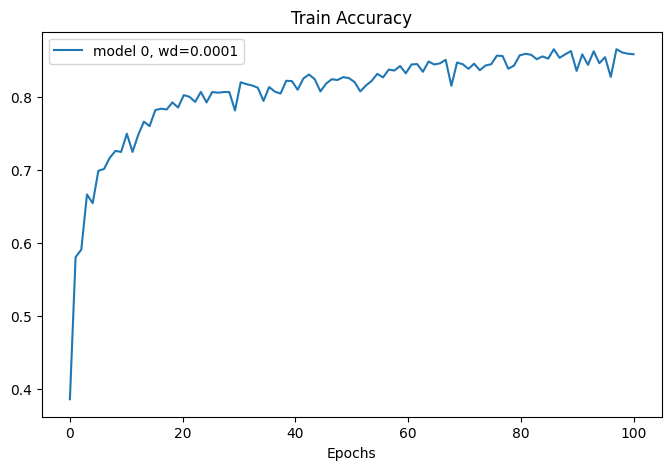

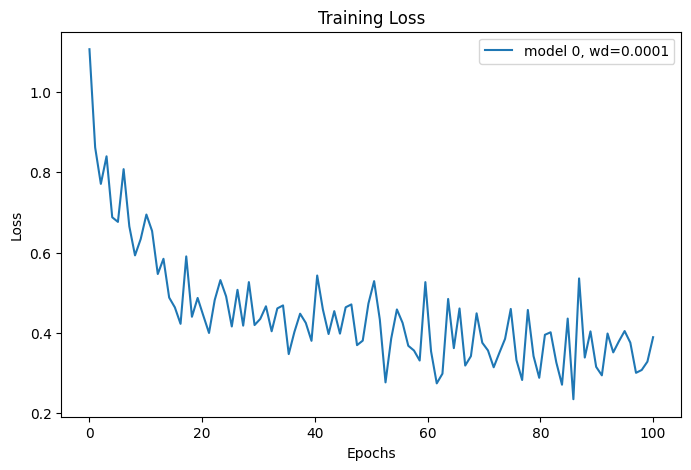

In [8]:
# Plot results from training
def plotAcc(models_label, models_acc):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Validation Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 1]
        plt.plot(np.linspace(0, len(valacc), len(valacc)), valacc, label=lab)
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")

    plt.figure(figsize=(8, 5))
    plt.title("Train Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 0]
        plt.plot(np.linspace(0, len(valacc), len(valacc)), valacc, label=lab)
    plt.legend()
    plt.xlabel("Epochs")


def plotLosses(models_label, models_losses):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Training Loss")
    for lab, loss in zip(models_label, models_losses):
        plt.plot(np.linspace(0, len(loss), len(loss)), loss, label=lab)
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    
def bestModelAcc(models_acc):
    """
    Prints test accuracy of best model
    Returns model that yields the best test accuracy
    """

    best_acc_idx = np.argmax([acc[-1, -1] for acc in models_acc])
    best_model = models[best_acc_idx]
    best_acc = getAcc(best_model, test=True)[0]
    print(f"Accuracy of test set of best model (idx={best_acc_idx}): {best_acc*100:.1f}%")
    return best_acc 

# Plot
plotAcc(models_label, models_acc)
plotLosses(models_label, models_losses)
# Print accuracy
acc_best_FC = bestModelAcc(models_acc)